In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession, functions as F, Window
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql import DataFrame
from functools import reduce
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import duckdb




In [12]:
try:
    SparkSession.builder.getOrCreate().stop()
except:
    pass


## Using parquet data to do research

In [13]:
spark = SparkSession.builder \
    .appName("MF810_Final_Project") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .getOrCreate()


path = "/Users/lucasking/Desktop/datasets/merged_cleaned.parquet"

# Covnert Parquet into DF
df = spark.read.parquet(path)
df = df.filter(F.col("ticker") != "merged_raw")


25/04/30 22:10:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [14]:
# test by AAPL
con = duckdb.connect()
df_aapl = (
    con
    .execute(f"""
        SELECT *
        FROM read_parquet('{path}')
        WHERE ticker = 'AAPL'
        LIMIT 5;
    """)
    .df()
)
print("=== DuckDB Query for AAPL ===")
print(df_aapl.head())

=== DuckDB Query for AAPL ===
   volume      vwap    open   close    high     low      timestamp  \
0  3056.0  164.0985  164.47  164.00  164.47  163.90  1680508800000   
1  1258.0  163.9985  164.00  164.00  164.00  164.00  1680508860000   
2   585.0  164.1085  164.09  164.09  164.09  164.09  1680508920000   
3   698.0  164.0203  164.02  164.00  164.03  164.00  1680508980000   
4  1888.0  164.0001  164.00  164.00  164.00  164.00  1680509040000   

   transactions             datetime ticker  
0           101  2023-04-03 08:00:00   AAPL  
1            42  2023-04-03 08:01:00   AAPL  
2            27  2023-04-03 08:02:00   AAPL  
3            20  2023-04-03 08:03:00   AAPL  
4             9  2023-04-03 08:04:00   AAPL  


### Convert datetime

In [15]:
df = df.withColumn("datetime", 
       F.to_timestamp("datetime", "yyyy-MM-dd HH:mm:ss")  
)
df.printSchema()  #check timestamp 


df2 = (df
    .withColumn("date" , F.to_date("datetime"))
    .withColumn("hour" , F.hour   ("datetime"))
)

# count trades in th day
(df2
 .groupBy("ticker", "date")
 .agg(F.count("*").alias("cnt"))
 .orderBy("ticker", "date")
 .show(10, truncate=False)
)

root
 |-- volume: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- transactions: long (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- ticker: string (nullable = true)



+------+----------+---+
|ticker|date      |cnt|
+------+----------+---+
|A     |2023-04-03|392|
|A     |2023-04-04|383|
|A     |2023-04-05|388|
|A     |2023-04-06|371|
|A     |2023-04-10|351|
|A     |2023-04-11|382|
|A     |2023-04-12|374|
|A     |2023-04-13|371|
|A     |2023-04-14|355|
|A     |2023-04-17|375|
+------+----------+---+
only showing top 10 rows



In [16]:
df2 = (df
       .withColumn("date",  F.to_date  ("datetime"))   
       .withColumn("hour",  F.hour     ("datetime"))   
       .withColumn("minute",F.minute   ("datetime"))   
       .withColumn("ts_trunc", F.date_trunc("day", "datetime"))  
      )

df2.printSchema()
df2.show(5, truncate=False)

root
 |-- volume: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- transactions: long (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- ticker: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- ts_trunc: timestamp (nullable = true)

+-------+--------+-------+--------+-------+------+-------------+------------+-------------------+------+----------+----+------+-------------------+
|volume |vwap    |open   |close   |high   |low   |timestamp    |transactions|datetime           |ticker|date      |hour|minute|ts_trunc           |
+-------+--------+-------+--------+-------+------+-------------+------------+-------------------+------+----------+----+------+-------------------+
|17632.0|137.0174

In [17]:
# Pick OCHL, vol, group by ticker,  date
df_daily = (
    df
    .withColumn("dt", F.to_date("datetime"))      
    .groupBy("ticker", "dt")                       
    .agg(
        F.first("open").alias("open"),           
        F.max  ("high").alias("high"),     
        F.min  ("low") .alias("low"),           
        F.last ("close").alias("close"),          
        F.sum  ("volume").alias("vol")        
    )
)

# top10 vol  tickers
top10 = (
    df_daily
    .groupBy("ticker")
    .agg(F.sum("vol").alias("total_vol"))
    .orderBy(F.desc("total_vol"))
    .limit(10)                
    .select("ticker")
    .rdd.flatMap(lambda r: r)
    .collect()
)
print("Top10 tickers:", top10)

# put back  to  pandas
df10 = (
    df_daily
    .filter(F.col("ticker").isin(top10))
    .orderBy("ticker", "dt")
    .toPandas()
)

#plot by Plotly Express 
fig = px.line(
    df10,
    x="dt", y="close",
    color="ticker",
    facet_col="ticker", facet_col_wrap=3,
    title="Top10 Volume Stocks Daily Close Price",
    labels={"dt": "Date", "close": "Close Price"}
)
fig.update_layout(height=600, width=900)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

Top10 tickers: ['NVDA', 'TSLA', 'PLTR', 'F', 'AMD', 'INTC', 'AAPL', 'AMZN', 'BAC', 'T']


In [18]:
df_raw = (
    spark.read.parquet(path)
         .withColumn("dt", F.to_date("datetime"))
)

df_recent = df_raw.filter(F.col("dt") >= "2024-03-01").filter(F.col("ticker") != "merged_raw")


df_daily_recent = (
    df_recent
    .groupBy("ticker", "dt")
    .agg(F.sum("volume").alias("vol"))
)


top10_recent = (
    df_daily_recent
    .groupBy("ticker")
    .agg(F.sum("vol").alias("total_vol"))
    .orderBy(F.desc("total_vol"))
    .limit(10)
    .select("ticker")
    .rdd.flatMap(lambda r: r).collect())

print("RECENTLY 1 year highest Vol. 10:", top10_recent)

RECENTLY 1 year highest Vol. 10: ['NVDA', 'TSLA', 'PLTR', 'INTC', 'F', 'AAPL', 'AMD', 'AMZN', 'NU', 'PFE']


In [ ]:
df10 = df10.sort_values(["ticker", "dt"])

fig = px.line(
    df10,
    x="dt", y="close",
    line_group="ticker",      
    facet_col="ticker", 
    facet_col_wrap=5,
    hover_name="ticker",
    labels={"dt":"Date", "close":"Close"},
    title="Top10 recent 1 year price"
)


fig.update_yaxes(matches=None)

fig.update_xaxes(tickformat="%b\n%Y")


fig.update_layout(
  hovermode="x unified",
  height=800, width=1200
)

fig.show()

In [20]:
def make_returns(sdf, trunc_unit, label):

    tcol = F.date_trunc(trunc_unit, "datetime").alias("ts")

    grp = (sdf
           .withColumn("ts", tcol)
           .groupBy("ticker", "ts")
           .agg(F.last("close").alias("close"))
           .orderBy("ticker", "ts"))

    w = Window.partitionBy("ticker").orderBy("ts")
    ret = ((F.col("close") - F.lag("close").over(w)) 
           / F.lag("close").over(w) * 100)

    return (grp
            .withColumn("return_pct", ret)
            .withColumn("period", F.lit(label))
            .select("ticker", "ts", "period", "close", "return_pct"))


hourly = make_returns(df, "hour",  "hourly")
daily  = make_returns(df, "day",   "daily")
weekly = make_returns(df, "week",  "weekly")



### describe the data to check errors, do ACF test

The result is that there is some outlier in hourly data (Max 6792%), and there are no significant autocorrelation

Firstly, I want to check if the errors are caused from low trading volune stock. Maybe the huge change rate is result from this reason, so check top100 stocks.

+------+-------+
|period|  count|
+------+-------+
|hourly|2322821|
| daily| 218660|
|weekly|  44349|
+------+-------+

            count      mean       std        min       25%       50%  \
period                                                                 
daily    218660.0  0.074960  1.944009 -39.694336 -0.827979  0.060366   
hourly  2322821.0  0.010175  4.501080 -98.540572 -0.206125  0.000000   
weekly    44349.0  0.377076  4.246722 -42.498205 -1.840857  0.296736   

             75%          max  
period                         
daily   0.961311    63.648124  
hourly  0.225395  6792.000000  
weekly  2.398082    79.063361  
Daily top-10% 異動後隔日反手空的win rate：50.5%


<Figure size 600x300 with 0 Axes>

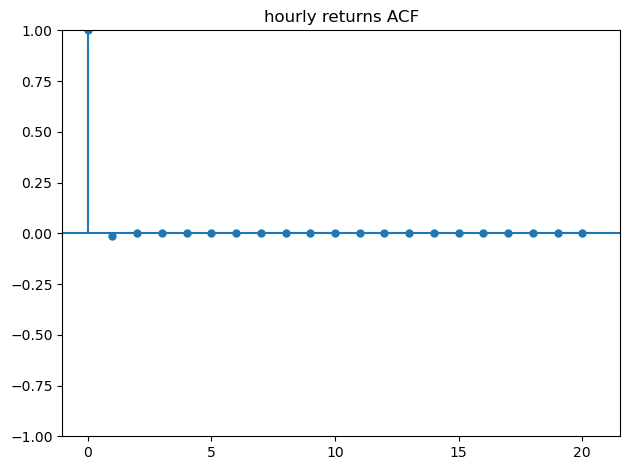

<Figure size 600x300 with 0 Axes>

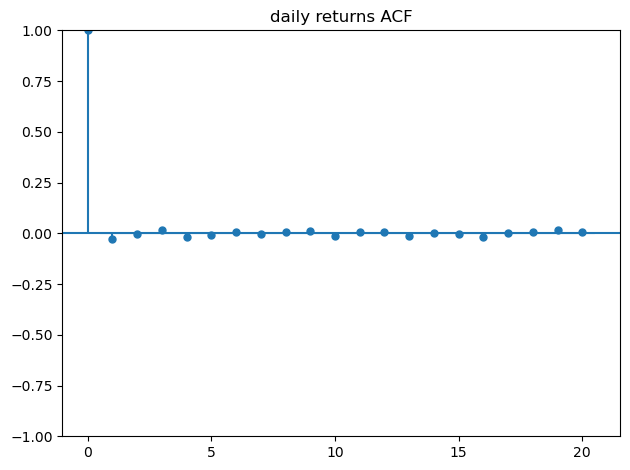

<Figure size 600x300 with 0 Axes>

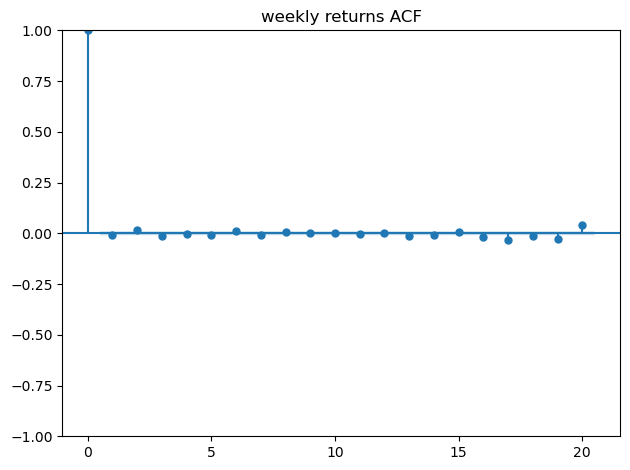

In [ ]:
all_ret = (hourly
           .unionByName(daily)
           .unionByName(weekly)
           .filter(F.col("return_pct").isNotNull())
            .cache()
          )


all_ret.groupBy("period").count().show()


pdf = all_ret.toPandas()


print(pdf.groupby("period")["return_pct"].describe())

# autocollelation


for per in ["hourly","daily","weekly"]:
    vals = pdf.loc[pdf.period==per, "return_pct"].dropna()
    plt.figure(figsize=(6,3))
    plot_acf(vals, lags=20, title=f"{per} returns ACF")
    plt.tight_layout()


daily = pdf[pdf.period=="daily"].copy()

th = daily.return_pct.quantile(0.9)
daily["next_return"] = daily.groupby("ticker")["return_pct"].shift(-1)
signal = daily.return_pct > th

win_rate = (daily.loc[signal, "next_return"] < 0).mean()
print(f"Daily top-10% Do opposite trade win rate：{win_rate:.1%}")

### Using only 100 for checking outliers

In [31]:
avg_vol = (
    df
      .groupBy("ticker")
      .agg(F.mean("volume").alias("avg_vol"))
)

top100 = (
    avg_vol
      .orderBy(F.desc("avg_vol"))
      .limit(100)
      .select("ticker")
)

# Only use top 100 to avoid outliers
top100_list = [r.ticker for r in top100.collect()]

filtered = df.filter(F.col("ticker").isin(top100_list))


hourly_top100 = make_returns(filtered, "hour",  "hourly")
daily_top100  = make_returns(filtered, "day",   "daily")
weekly_top100 = make_returns(filtered, "week",  "weekly")


all_ret_top100 = (
    hourly_top100.unionByName(daily_top100)
                   .unionByName(weekly_top100)
                   .filter(F.col("return_pct").isNotNull())
)

pdf_top100 = all_ret_top100.toPandas()
print(pdf_top100.groupby("period")["return_pct"].describe())

           count      mean       std        min       25%       50%       75%  \
period                                                                          
daily    52729.0  0.090136  2.377502 -28.690391 -0.933616  0.028337  1.052016   
hourly  693224.0  0.016619  8.185208 -98.540572 -0.202293  0.000000  0.219832   
weekly   10362.0  0.464146  5.316984 -31.587189 -2.204876  0.233169  2.738692   

                max  
period               
daily     63.648124  
hourly  6792.000000  
weekly    62.349824  


In [23]:
# find outlier
extreme_thresh = 100  # pisk outliers threshold
outliers = pdf[ pdf.return_pct.abs() > extreme_thresh ]
print("Outlier:（ticker, period, ts, return_pct）:")
print(outliers[["ticker","period","ts","return_pct"]])

Outlier:（ticker, period, ts, return_pct）:
        ticker  period                  ts  return_pct
1477156   GOLD  hourly 2024-06-03 14:00:00      6792.0


In [32]:
extreme_thresh = 100  # 100%
outlier_tickers = pdf.loc[pdf.return_pct.abs() > extreme_thresh, 'ticker'].unique()
print("Detected outlier tickers:", outlier_tickers)

pdf_clean = pdf[~pdf.ticker.isin(outlier_tickers)].copy()


desc = pdf_clean.groupby('period')['return_pct'].describe()
print("\nAfter dropping outliers, return_pct describe:\n", desc)



Detected outlier tickers: ['GOLD']

After dropping outliers, return_pct describe:
             count      mean       std        min       25%       50%  \
period                                                                 
daily    218123.0  0.075080  1.944165 -39.694336 -0.827739  0.060551   
hourly  2314921.0  0.007311  0.629344 -35.540102 -0.206186  0.000000   
weekly    44245.0  0.377735  4.246057 -42.498205 -1.838755  0.297915   

             75%        max  
period                       
daily   0.961074  63.648124  
hourly  0.225479  44.060886  
weekly  2.397434  79.063361  


# LSTM model

In [ ]:
df_aapl = df10[df10['ticker']=='AAPL'].sort_values('dt')

# get volume
data = df_aapl[['close','vol']].values


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# LSTM model
# rolloing window, predict next close price
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        
        y.append(data[i+seq_len, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 20
X, y = create_sequences(data_scaled, SEQ_LEN)

# train/ test  80/20
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [26]:
model = Sequential([
    LSTM(32, input_shape=(SEQ_LEN, 2)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0914 - val_loss: 0.1326
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - val_loss: 0.0327
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.0468
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0061
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0019

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


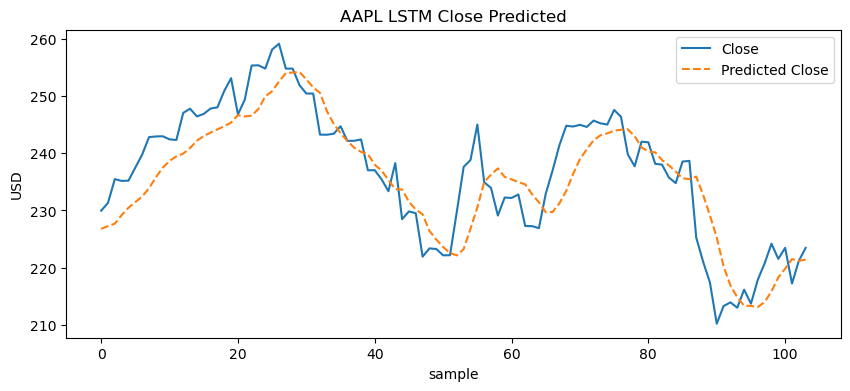

In [27]:
y_pred = model.predict(X_test)

dummy = np.zeros((len(y_pred), 2))
dummy[:,0] = y_pred.flatten()
inv_pred = scaler.inverse_transform(dummy)[:,0]

dummy[:,0] = y_test
inv_true = scaler.inverse_transform(dummy)[:,0]


plt.figure(figsize=(10,4))
plt.plot(inv_true, label='Close')
plt.plot(inv_pred, label='Predicted Close', linestyle='--')
plt.title("AAPL LSTM Close Predicted")
plt.xlabel("sample")
plt.ylabel("USD")
plt.legend()
plt.show();

In [28]:
mse   = mean_squared_error(inv_true, inv_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(inv_true, inv_pred)
r2    = r2_score(inv_true, inv_pred)

print(f"MSE:   {mse:.4f}")
print(f"RMSE:  {rmse:.4f} USD")
print(f"MAE:   {mae:.4f} USD")
print(f"R²:    {r2:.4f}")

MSE:   32.6608
RMSE:  5.7150 USD
MAE:   4.6047 USD
R²:    0.7523


In [39]:
df_aapl = df10[df10['ticker']=='TSLA'].sort_values('dt')

# get volume
data = df_aapl[['close','vol']].values


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# LSTM model
# rolloing window, predict next close price
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        
        y.append(data[i+seq_len, 0])
    return np.array(X), np.array(y)

SEQ_LEN = 20
X, y = create_sequences(data_scaled, SEQ_LEN)

# train/ test  80/20
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [40]:
model = Sequential([
    LSTM(32, input_shape=(SEQ_LEN, 2)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0909 - val_loss: 0.0642
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0172
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0372
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0336
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0235
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0243
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0223
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0189
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0181
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0162
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0131
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0141

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


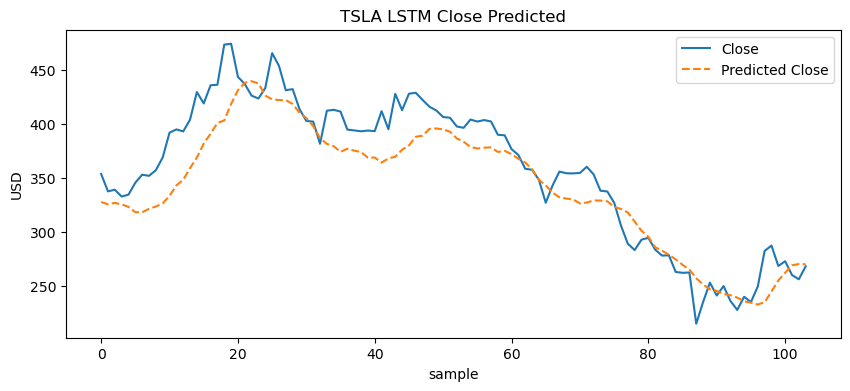

In [41]:
y_pred = model.predict(X_test)

dummy = np.zeros((len(y_pred), 2))
dummy[:,0] = y_pred.flatten()
inv_pred = scaler.inverse_transform(dummy)[:,0]

dummy[:,0] = y_test
inv_true = scaler.inverse_transform(dummy)[:,0]


plt.figure(figsize=(10,4))
plt.plot(inv_true, label='Close')
plt.plot(inv_pred, label='Predicted Close', linestyle='--')
plt.title("TSLA LSTM Close Predicted")
plt.xlabel("sample")
plt.ylabel("USD")
plt.legend()
plt.show();

In [42]:
mse   = mean_squared_error(inv_true, inv_pred)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(inv_true, inv_pred)
r2    = r2_score(inv_true, inv_pred)

print(f"MSE:   {mse:.4f}")
print(f"RMSE:  {rmse:.4f} USD")
print(f"MAE:   {mae:.4f} USD")
print(f"R²:    {r2:.4f}")

MSE:   709.9782
RMSE:  26.6454 USD
MAE:   21.0781 USD
R²:    0.8384


In [49]:
from pyspark.sql import SparkSession, functions as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd

# 初始化 SparkSession
spark = SparkSession.builder.getOrCreate()

# 1. 讀取資料
df = spark.read.parquet(path)
df = df.filter(F.col("ticker") != "merged_raw")

# 2. 擷取所有 ticker 名單
tickers = [row['ticker'] for row in df.select('ticker').distinct().collect()]

r2_scores = []

# 3. 為每個 ticker 執行 LSTM 模型訓練與評估
SEQ_LEN = 20

for ticker in tickers:
    print(f"Processing {ticker}...")

    # 取得該 ticker 的資料並轉成 pandas
    df_ticker = df.filter(F.col("ticker") == ticker).orderBy("datetime").select("close", "volume")
    pdf = df_ticker.toPandas().dropna()

    if len(pdf) < SEQ_LEN + 10:  # 資料太少就跳過
        continue

    # 正規化
    data = pdf[['close', 'volume']].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # 建立序列
    X, y = [], []
    for i in range(len(data_scaled) - SEQ_LEN):
        X.append(data_scaled[i:i+SEQ_LEN])
        y.append(data_scaled[i+SEQ_LEN, 0])  # close price

    X, y = np.array(X), np.array(y)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # LSTM 模型
    model = Sequential()
    model.add(LSTM(50, input_shape=(SEQ_LEN, 2)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

    # 預測與評估 R²
    y_pred = model.predict(X_test).flatten()
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    print(f"{ticker} R²: {r2:.4f}")

# 4. 計算平均 R²
if r2_scores:
    avg_r2 = sum(r2_scores) / len(r2_scores)
    print(f"\n✅ Average R² across all tickers: {avg_r2:.4f}")
else:
    print("⚠️ No valid tickers for evaluation.")

Processing AAPL...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9327/9327 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0011
Epoch 2/10
9327/9327 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 4.4927e-06
Epoch 3/10
9327/9327 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.6513e-06
Epoch 4/10
9327/9327 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.4988e-06
Epoch 5/10
9327/9327 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.1052e-06
Epoch 6/10
9327/9327 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.2810e-06
Epoch 7/10
9327/9327 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.0858e-06
Epoch 8/10
9327/9327 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.6176e-06
Epoch 9/10
9327/9327 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.1620e-06
Epoch 10/10
9327/9327 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.0310e-06
2332/2332 ━━━━━━━━━━━━━━━━━━━━ 2s 689us/step
AAPL R²: 0.9996
Processing AJG...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4088/4088 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0017
Epoch 2/10
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.8652e-06
Epoch 3/10
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.8565e-06
Epoch 4/10
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 3.3885e-06
Epoch 5/10
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.6686e-06
Epoch 6/10
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.5139e-06
Epoch 7/10
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.4238e-06
Epoch 8/10
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 2.2405e-06
Epoch 9/10
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.3990e-06
Epoch 10/10
4088/4088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.2796e-06
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step
AJG R²: 0.9998
Processing ACGL...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4720/4720 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 5.5568e-04
Epoch 2/10
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 8.5170e-06
Epoch 3/10
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6.2122e-06
Epoch 4/10
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.3742e-06
Epoch 5/10
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.7677e-06
Epoch 6/10
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.2698e-06
Epoch 7/10
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.2725e-06
Epoch 8/10
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.8007e-06
Epoch 9/10
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.7912e-06
Epoch 10/10
4720/4720 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.2978e-06
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 1s 607us/step
ACGL R²: 0.9992
Processing ADP...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4625/4625 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0017
Epoch 2/10
4625/4625 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.0012e-05
Epoch 3/10
4625/4625 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.7037e-06
Epoch 4/10
4625/4625 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.3549e-06
Epoch 5/10
4625/4625 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.5505e-06
Epoch 6/10
4625/4625 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.0844e-06
Epoch 7/10
4625/4625 ━━━━━━━━━━━━━━━━━━━━ 78s 17ms/step - loss: 3.2156e-06
Epoch 8/10
4625/4625 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 3.2545e-06
Epoch 9/10
4625/4625 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 3.0896e-06
Epoch 10/10
4625/4625 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.0211e-06
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step
ADP R²: 0.9987
Processing ALC...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4454/4454 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0014
Epoch 2/10
4454/4454 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.5384e-05
Epoch 3/10
4454/4454 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.1500e-05
Epoch 4/10
4454/4454 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 8.3470e-06
Epoch 5/10
4454/4454 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 7.7415e-06
Epoch 6/10
4454/4454 ━━━━━━━━━━━━━━━━━━━━ 83s 19ms/step - loss: 7.1290e-06
Epoch 7/10
4454/4454 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.4957e-06
Epoch 8/10
4454/4454 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.7747e-06
Epoch 9/10
4454/4454 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 5.7042e-06
Epoch 10/10
4454/4454 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 7.3588e-06
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step
ALC R²: 0.9993
Processing ALL...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4633/4633 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0026
Epoch 2/10
1016/4633 ━━━━━━━━━━━━━━━━━━━━ 17:08 284ms/step - loss: 8.4195e-06

25/05/01 00:29:52 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 289919 ms exceeds timeout 120000 ms
25/05/01 00:29:52 WARN SparkContext: Killing executors is not supported by current scheduler.


4633/4633 ━━━━━━━━━━━━━━━━━━━━ 295s 64ms/step - loss: 8.1410e-06
Epoch 3/10
 169/4633 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.1789e-06

25/05/01 00:29:59 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4633/4633 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.6316e-06
Epoch 4/10
1701/4633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.3290e-06

25/05/01 00:30:09 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4633/4633 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 4.2785e-06
Epoch 5/10
3227/4633 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.3605e-06

25/05/01 00:30:19 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4633/4633 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.3698e-06
Epoch 6/10
4633/4633 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.1947e-06
Epoch 7/10
  97/4633 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.8587e-06

25/05/01 00:30:29 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4633/4633 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.1533e-06
Epoch 8/10
1627/4633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.6003e-06

25/05/01 00:30:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4633/4633 ━━━━━━━━━━━━━━━━━━━━ 589s 127ms/step - loss: 2.7054e-06
Epoch 9/10
2770/4633 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.5559e-06

25/05/01 00:40:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4633/4633 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.3042e-06
Epoch 10/10
4280/4633 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6168e-06

25/05/01 00:40:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4633/4633 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 2.6179e-06
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step
ALL R²: 0.9976
Processing A...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4007/4727 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028

25/05/01 00:40:50 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4727/4727 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0024
Epoch 2/10
4727/4727 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.8901e-05
Epoch 3/10
 325/4727 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.4673e-05

25/05/01 00:41:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4727/4727 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.3238e-05
Epoch 4/10
1400/4727 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.3498e-06

25/05/01 00:41:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4727/4727 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 8.9203e-06
Epoch 5/10
2392/4727 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.8721e-06

25/05/01 00:41:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4727/4727 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 9.1868e-06
Epoch 6/10
3408/4727 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.3879e-06

25/05/01 00:41:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4727/4727 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 7.4403e-06
Epoch 7/10
4424/4727 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1115e-06

25/05/01 00:41:40 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4727/4727 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 8.0900e-06
Epoch 8/10
4727/4727 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 7.7654e-06
Epoch 9/10
 628/4727 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.7923e-06

25/05/01 00:41:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4727/4727 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 7.0815e-06
Epoch 10/10
1671/4727 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.7595e-06

25/05/01 00:42:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4727/4727 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 8.4024e-06
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step
A R²: 0.9996
Processing ABT...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1599/5021 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0028

25/05/01 00:42:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

5021/5021 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0011
Epoch 2/10
2686/5021 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.6611e-06

25/05/01 00:42:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

5021/5021 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 8.4210e-06
Epoch 3/10
3727/5021 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.7538e-06

25/05/01 00:42:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

5021/5021 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.6630e-06
Epoch 4/10
4809/5021 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5170e-06

25/05/01 00:42:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

5021/5021 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.5032e-06
Epoch 5/10
5021/5021 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.0395e-06
Epoch 6/10
 814/5021 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 4.4376e-06

25/05/01 00:42:50 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

5021/5021 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.8676e-06
Epoch 7/10
1948/5021 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.8942e-06

25/05/01 00:43:00 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

5021/5021 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.7301e-06
Epoch 8/10
2953/5021 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3.4677e-06

25/05/01 00:43:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

5021/5021 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.5302e-06
Epoch 9/10
4015/5021 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8394e-06

25/05/01 00:43:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

5021/5021 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.8051e-06
Epoch 10/10
5021/5021 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.5481e-06


25/05/01 00:43:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step
ABT R²: 0.9998
Processing AEP...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4378/4955 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.0016

25/05/01 00:46:04 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4955/4955 ━━━━━━━━━━━━━━━━━━━━ 154s 31ms/step - loss: 0.0014
Epoch 2/10
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.2021e-05
Epoch 3/10
 422/4955 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.0603e-06

25/05/01 00:46:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4955/4955 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 6.5579e-06
Epoch 4/10
1353/4955 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.2840e-06

25/05/01 00:46:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4955/4955 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.0399e-06
Epoch 5/10
2316/4955 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.2271e-06

25/05/01 00:46:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4955/4955 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.4346e-06
Epoch 6/10
3339/4955 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1382e-06

25/05/01 00:46:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4955/4955 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.2815e-06
Epoch 7/10
4294/4955 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9655e-06

25/05/01 00:46:54 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4955/4955 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.9964e-06
Epoch 8/10
4955/4955 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.1064e-06
Epoch 9/10
 292/4955 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.8498e-06

25/05/01 00:47:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4955/4955 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.3979e-06
Epoch 10/10
1229/4955 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3.7211e-06

25/05/01 00:47:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4955/4955 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.9508e-06
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step
AEP R²: 0.9996
Processing ADI...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 536/4989 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0126

25/05/01 00:47:24 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4989/4989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0020
Epoch 2/10
1217/4989 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.9454e-05

25/05/01 00:47:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4989/4989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.9170e-05
Epoch 3/10
1885/4989 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1460e-05

25/05/01 00:47:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4989/4989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.1645e-05
Epoch 4/10
2506/4989 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.9086e-06

25/05/01 00:47:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4989/4989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 9.9061e-06
Epoch 5/10
3149/4989 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.9193e-06

25/05/01 00:48:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4989/4989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 8.1402e-06
Epoch 6/10
3808/4989 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0151e-05

25/05/01 00:48:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4989/4989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 9.8046e-06
Epoch 7/10
4416/4989 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3305e-06

25/05/01 00:48:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4989/4989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 8.3675e-06
Epoch 8/10
4989/4989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 8.2690e-06
Epoch 9/10
   1/4989 ━━━━━━━━━━━━━━━━━━━━ 51s 10ms/step - loss: 4.2159e-06

25/05/01 00:48:34 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4989/4989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 9.9793e-06
Epoch 10/10
 591/4989 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 9.5552e-06

25/05/01 00:48:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4989/4989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 8.9025e-06
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 1s 613us/step
ADI R²: 0.9990
Processing ADSK...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

25/05/01 00:48:54 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.rep

4634/4634 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 3.8532e-04
Epoch 2/10
 830/4634 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.0922e-05

25/05/01 00:49:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4634/4634 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 9.7228e-06
Epoch 3/10
1603/4634 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.4368e-06

25/05/01 00:49:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4634/4634 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 6.2781e-06
Epoch 4/10
2476/4634 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.9896e-06

25/05/01 00:49:24 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4634/4634 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.1855e-06
Epoch 5/10
3330/4634 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1695e-06

25/05/01 00:49:34 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4634/4634 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.1076e-06
Epoch 6/10
4155/4634 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0811e-06

25/05/01 00:49:44 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4634/4634 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.0533e-06
Epoch 7/10
4634/4634 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.0884e-06
Epoch 8/10
 357/4634 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.1073e-06

25/05/01 00:49:54 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4634/4634 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.9675e-06
Epoch 9/10
1208/4634 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.2850e-06

25/05/01 00:50:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4634/4634 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.5466e-06
Epoch 10/10
2114/4634 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.2401e-06

25/05/01 00:50:14 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4634/4634 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4.4205e-06
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step
ADSK R²: 0.9991
Processing ACN...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1828/4900 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0032

25/05/01 00:50:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4900/4900 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0014
Epoch 2/10
2523/4900 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.3190e-05

25/05/01 00:50:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4900/4900 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.3194e-05
Epoch 3/10
3169/4900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.8372e-06

25/05/01 00:50:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4900/4900 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 8.7011e-06
Epoch 4/10
3798/4900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3170e-06

25/05/01 00:50:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4900/4900 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 8.0061e-06
Epoch 5/10
4523/4900 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5121e-06

25/05/01 00:51:04 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

4900/4900 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 7.4586e-06
Epoch 6/10
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6.5501e-06
Epoch 7/10
 353/4900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 7.5497e-06

25/05/01 00:51:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4900/4900 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6.8332e-06
Epoch 8/10
1003/4900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 6.4975e-06

25/05/01 00:51:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4900/4900 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6.1561e-06
Epoch 9/10
1461/4900 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 5.3962e-06

25/05/01 00:51:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4900/4900 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6.2510e-06
Epoch 10/10
2117/4900 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.1925e-06

25/05/01 00:51:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

4900/4900 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 6.1520e-06
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step
ACN R²: 0.9993
Processing ABEV...
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1262/5050 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0099

25/05/01 00:51:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

5050/5050 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0031
Epoch 2/10
1956/5050 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.9238e-05

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51349)
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/anaconda3/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/opt/anaconda3/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/anaconda3/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/opt/anaconda3/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/anaconda3/lib/python3.12/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-pac

5050/5050 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.8854e-05
Epoch 3/10
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.5360e-05
Epoch 4/10
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.2588e-05
Epoch 5/10
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.1793e-05
Epoch 6/10
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.1326e-05
Epoch 7/10
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.1897e-05
Epoch 8/10
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.1131e-05
Epoch 9/10
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.1680e-05
Epoch 10/10
5050/5050 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.0982e-05
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step
ABEV R²: 0.9994
Processing AIG...


ConnectionRefusedError: [Errno 61] Connection refused